In [12]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')

from sparse_rrt import _deep_smp_module
# from params.cpp_dst_s32_e4 import get_params

def experiment_vis(env_id, traj_id, verbose=False, system='cartpole_obs', params=None, ax=None, bx=None, number_of_iterations=1):
    print("env {}, traj {}".format(env_id, traj_id))
    obs_list = get_obs(system, env_id)[env_id].reshape(-1, 2)
    data = load_data(system, env_id, traj_id)
    ref_path = data['path']
    start_goal = data['start_goal']
    # print(start_goal)
    env_vox = np.load('mpnet/sst_envs/{}_env_vox.npy'.format(system))
    obc = env_vox[env_id, 0]
    # print(obs_list)
    params = params
    #number_of_iterations = params['number_of_iterations'] #3000000# 
    min_time_steps = params['min_time_steps'] if 'min_time_steps' in params else 80
    max_time_steps = params['max_time_steps'] if 'min_time_steps' in params else 400
    integration_step = params['dt']
    
    ax.scatter(ref_path[0][0], ref_path[0][2], color='orange')
    ax.scatter(ref_path[-1][0], ref_path[-1][2], color='red')

    planner = _deep_smp_module.DSSTMPCWrapper(
        system_type=system,
        start_state=np.array(ref_path[0]),
    #             goal_state=np.array(ref_path[-1]),
        goal_state=np.array(data['start_goal'][-1]),
        goal_radius=params['goal_radius'],
        random_seed=0,
        sst_delta_near=params['sst_delta_near'],
        sst_delta_drain=params['sst_delta_drain'],
        obs_list=obs_list,
        width=params['width'],
        verbose=params['verbose'],
        mpnet_weight_path=params['mpnet_weight_path'], 
        cost_predictor_weight_path=params['cost_predictor_weight_path'],
        cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
        num_sample=params['cost_samples'],
        ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
        converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
        std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
        device_id=params['device_id'], refine_lr=params['refine_lr'],
        weights_array=params['weights_array'],
        obs_voxel_array=obc.reshape(-1)
    )
    return data, planner
    


# /home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/neural_test_visualization_mpnet.py


def draw_obs(env_id, system, ax=None):
    def line_line_cc(x1, y1, x2, y2, x3, y3, x4, y4):
        uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        if uA >= 0. and uA <= 1. and uB >= 0. and uB <= 1.:
            # intersection
            return True
        # collision free
        return False
    def IsInCollision(x, obc, obc_width=4.):
        I = 10
        L = 2.5
        M = 10
        m = 5
        g = 9.8
        H = 0.5

        STATE_X = 0
        STATE_V = 1
        STATE_THETA = 2
        STATE_W = 3
        CONTROL_A = 0

        MIN_X = -30
        MAX_X = 30
        MIN_V = -40
        MAX_V = 40
        MIN_W = -2
        MAX_W = 2


        if x[0] < MIN_X or x[0] > MAX_X:
            return True

        H = 0.5
        pole_x1 = x[0]
        pole_y1 = H
        pole_x2 = x[0] + L * np.sin(x[2])
        pole_y2 = H + L * np.cos(x[2])

        width = 4
        for i in range(len(obc)):
            for j in range(0, 8, 2):
                x1 = obc[i][j]
                y1 = obc[i][j+1]
                x2 = obc[i][(j+2) % 8]
                y2 = obc[i][(j+3) % 8]
                if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                    return True
        return False
    _obs_list = get_obs(system, env_id)[env_id]#.reshape(-1, 2)
    obs_list = []
    width = 4
    for i in range(len(_obs_list)):
        x = _obs_list[i][0];
        y = _obs_list[i][1];
        obs = np.zeros(8)
        obs[0] = x - width / 2;  obs[1] = y + width / 2;
        obs[2] = x + width / 2;  obs[3] = y + width / 2;
        obs[4] = x + width / 2;  obs[5] = y - width / 2;
        obs[6] = x - width / 2;  obs[7] = y - width / 2;
        obs_list.append(obs)
    obs_i = np.array(obs_list)
        
#     print(obs_i)

    dx = 1
    dtheta = 0.1
    feasible_points = []
    infeasible_points = []
    imin = 0
    imax = int(2*30./dx)
    jmin = 0
    jmax = int(2*np.pi/dtheta)

    for i in range(imin, imax):
        for j in range(jmin, jmax):
            x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
            if IsInCollision(x, obs_i):
                infeasible_points.append(x)
            else:
                feasible_points.append(x)
    feasible_points = np.array(feasible_points)
    infeasible_points = np.array(infeasible_points)
    # print('feasible points')
    # print(feasible_points)
    # print('infeasible points')
    # print(infeasible_points)
    ax.scatter(feasible_points[:,0], feasible_points[:,2], c='azure')
    ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c='slategray')


In [15]:
env_id = 0
traj_id = 1801
system = 'cartpole_obs'
config = 'default'

params = {
        'n_sample': 128,
        'n_elite': 4,
        'n_t': 3,
        'max_it': 5,
        'converge_r': 1e-3,
        
        'dt': 2e-3,

        'mu_u': 0,
        'sigma_u': 300,

        'mu_t': 5e-2,
        'sigma_t': 0.1,
        't_max': 1,

        'verbose': True, #False,#
        'step_size': 0.75,

        "goal_radius": 1.5,

        "sst_delta_near": 2,
        "sst_delta_drain": 0.1,
        "goal_bias": 0.1,

        "width": 4,
        "hybrid": False,#True,#
        "hybrid_p": 0,#1,

        "cost_samples": 20,
        "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_pos_vel_external.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v3_multigoal.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v2_deep.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_branch.pt",


        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_nonorm.pt",
        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_subsample0.5_10k.pt",

        "cost_predictor_weight_path": "mpnet/exported/output/cartpole_obs/cost_10k.pt",
        "cost_to_go_predictor_weight_path": "mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0,
        "refine_threshold": 0,
        "device_id": "cuda:3",

        "cost_reselection": False,
        "number_of_iterations": 500,
        "weights_array": [1, 1, 1, 1],

    }
def visualize_pair(start, sample, actual, ax=plt, bx=plt):
    # for state
    ax.scatter(start[0], start[2], c='blue')
    ax.scatter(sample[0], sample[2], c='skyblue')
    ax.plot([start[0], sample[0]], [start[2], sample[2]], color='skyblue')
    
    ax.scatter(actual[0], actual[2], c='green')
    ax.plot([start[0], actual[0]], [start[2], actual[2]], color='lime')
    
    # for state dot
    bx.scatter(start[1], start[3], c='blue')
    bx.scatter(sample[1], sample[3], c='skyblue')
    bx.plot([start[1], sample[1]], [start[3], sample[3]], color='skyblue')
    
    bx.scatter(actual[1], actual[3], c='green')
    bx.plot([start[1], actual[1]], [start[3], actual[3]], color='lime')

<ipython-input-12-275e086aa3da>:68: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
<ipython-input-12-275e086aa3da>:69: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


env 0, traj 1801
0.010929739102721214
0.0056646037846803665
0.011775024235248566
0.010254228487610817
0.012093333527445793
0.0025747213512659073
0.00026919320225715637
0.00027070939540863037
0.00023788772523403168
0.00029941461980342865
0.0002893023192882538
0.0002744775265455246
0.00025689974427223206
0.00028990209102630615
0.0003019273281097412
0.00027051568031311035
0.00029702670872211456
0.00024345889687538147
0.0002964045852422714
0.0002995971590280533
0.0002752766013145447
0.0002949945628643036
0.00026243552565574646
0.00027053989470005035
0.0003157239407300949
0.0003010425716638565
0.00028072111308574677
0.0003198329359292984
0.0003190562129020691
0.000298183411359787
0.0003217589110136032
0.00032012350857257843
0.00031619705259799957
0.00027482956647872925
0.0003034006804227829
0.0002537909895181656
0.00028010644018650055
0.0002560243010520935
0.0002727638930082321
0.00031177885830402374
0.0003023110330104828
0.0002509523183107376
0.0003100261092185974
0.0003081373870372772
tot

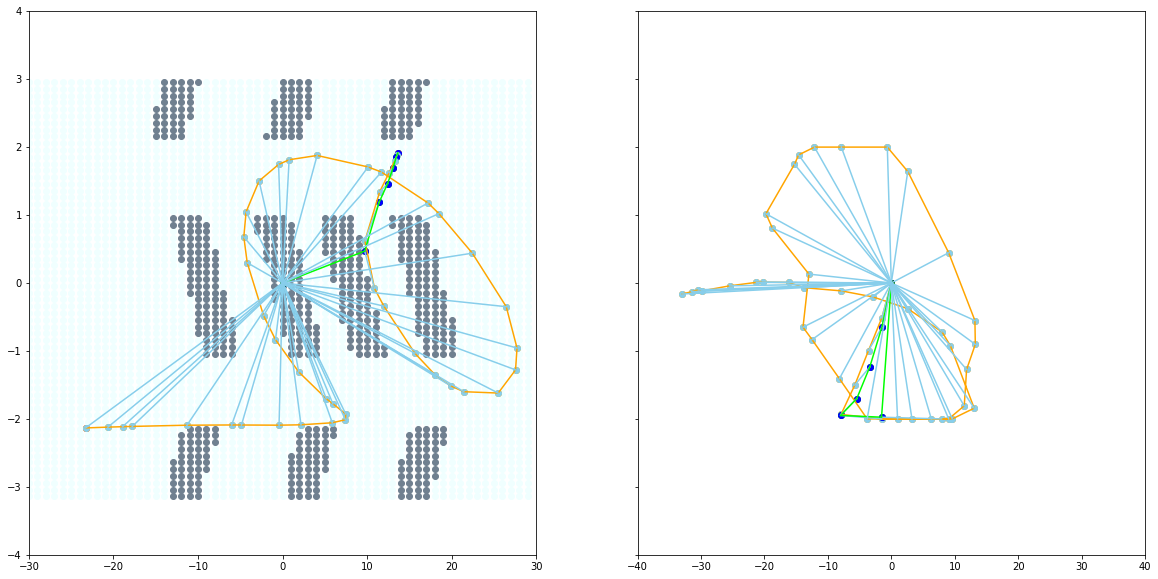

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

ax.set_xlim(-30, 30)
ax.set_ylim(-3.14, 3.14)

bx.set_xlim(-40, 40)
bx.set_ylim(-4, 4)
draw_obs(env_id, system, ax)

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='cartpole_obs', 
                    params=params, 
                    ax=ax, 
                    bx=bx,
                    number_of_iterations=params['number_of_iterations'])

ref_path = data['path']
ax.scatter(ref_path[:, 0], ref_path[:, 2], color='orange')
ax.plot(ref_path[:, 0], ref_path[:, 2], color='orange')

bx.scatter(ref_path[:, 1], ref_path[:, 3], color='orange')
bx.plot(ref_path[:, 1], ref_path[:, 3], color='orange')

import time

state = ref_path[0]
full_time = 0
for i in range(len(ref_path)-1):
    tic = time.perf_counter()
#     state, sample, actual_state = ref_path[i], ref_path[i+1], planner.steer(ref_path[i], ref_path[i+1])
    sample = ref_path[i+1].copy()
    actual_state = planner.steer(state.copy(), sample.copy())
#     print(state, sample, actual_state)
    toc = time.perf_counter()
    time_cost = toc - tic
    full_time += time_cost
    print(time_cost)
    visualize_pair(state, sample, actual_state, ax, bx)
    state = actual_state.copy()
print("total: {}".format(full_time))


<ipython-input-1-275e086aa3da>:68: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
<ipython-input-1-275e086aa3da>:69: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


env 0, traj 1801


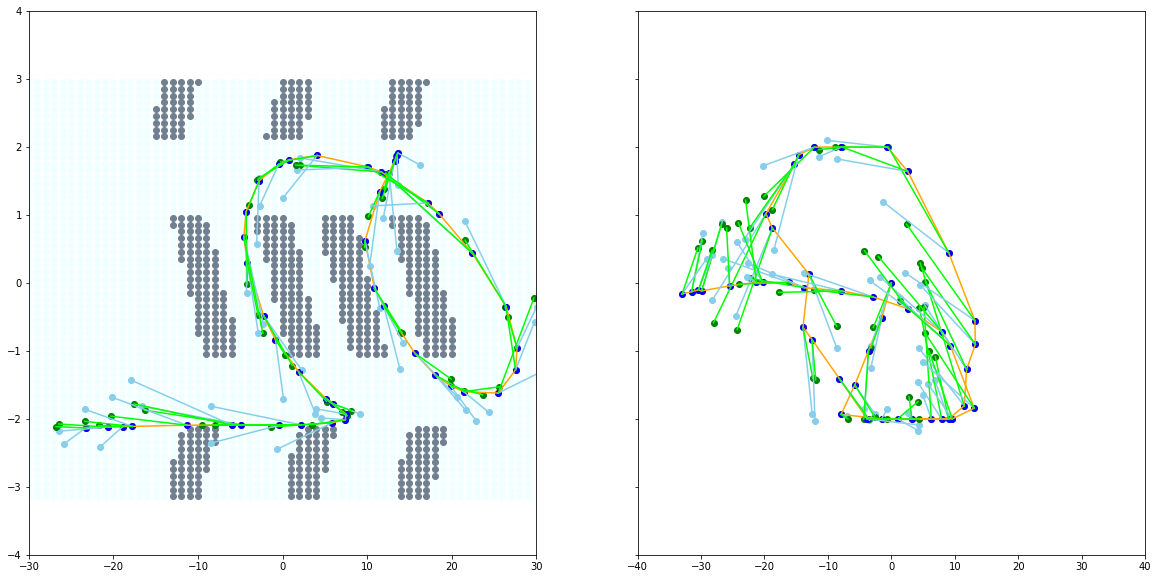

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

ax.set_xlim(-30, 30)
ax.set_ylim(-3.14, 3.14)

bx.set_xlim(-40, 40)
bx.set_ylim(-4, 4)
draw_obs(env_id, system, ax)

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='cartpole_obs', 
                    params=params, 
                    ax=ax, 
                    bx=bx,
                    number_of_iterations=params['number_of_iterations'])
ref_path = data['path']
ax.scatter(ref_path[:, 0], ref_path[:, 2], color='orange')
ax.plot(ref_path[:, 0], ref_path[:, 2], color='orange')

bx.scatter(ref_path[:, 1], ref_path[:, 3], color='orange')
bx.plot(ref_path[:, 1], ref_path[:, 3], color='orange')


# i = 3

for i in range(len(ref_path)):
    start, sample  = ref_path[i], planner.neural_sample(ref_path[i]), 
    actual_state = planner.steer(ref_path[i], sample)

    visualize_pair(start, sample, actual_state, ax, bx)
    